## About me
- Michael F. Herbst (Postdoc wtih Benjamin Stamm @ RWTH Aachen, Germany)
- https://michael-herbst.com


- Lead developer of DFTK (Julia code for density-functional theory, electronic structure theory)  
  (together with some folks from Ecole des Ponts)
- https://dftk.org


- In my research I work with Julia, Python and C++
- Learned Julia in 2018, quickly became my favourite language
- Today I tell you why!

- You can get these notes from https://github.com/mfherbst/julia-one-hour-intro

## The point of  Julia

- **Walks like Python, talks like Lisp, runs like FORTRAN**
    - Development dynamic like writing python code
    - Less object-oriented more function-oriented (like Lisp)
    - Same speed as FORTRAN or C code (Petaflop club)
- *Both* fast and high-level!
- Extremely good ratio between coding time and running time.



- Key concepts:
    - **Just-in-time compilation** (JIT)
    - Compilation down to *native code* (running on CPU and GPU, ...)
    - Strong type system to encode exploitable properties (e.g. symmetries, sparsities, storage location etc.)
    - Multiple dispatch and strong composability of packages (Details later)
    
    

- Additional value:
    - **Multi-platform** (x86, ARM, PowerPC, Apple's M1 on the way)
    - **Cross-language support:** Easily use C++, FORTRAN, python, R, Java ... from Julia (and in some cases the other way round, too)
    - **Builtin package manager**
    - **Unicode support** inside the core language
    - **Green threading** and **distributed computing**
    - **Macros** are part of the language
    - **Rich set of packages**: GPU, Threading, Distributed computing, Plotting, Visualisation, Optimisation, Statistics, Data science, Automatic differentiation, Machine Learning, PDEs ...

## Just-in-time compilation

Consider the case of summing the numbers in a vector:

In [1]:
function mysum(v)
    result = zero(eltype(v))
    for i in 1:length(v)
        result += v[i]
    end
    result
end

mysum (generic function with 1 method)

In [2]:
v = rand(5000);

First run is always slow (compilation):

In [3]:
@time mysum(v);

  0.007224 seconds (14.92 k allocations: 959.666 KiB, 99.20% compilation time)


Afterwards way faster:

In [4]:
@time mysum(v);

  0.000009 seconds (1 allocation: 16 bytes)


Employed arithmetic depends on types:

In [5]:
vint = rand(Int, 10);
mysum(vint)

3412271391523101405

## Composability

or the real power of Julia.


(a) **Elevated precision** ... let's consider a nasty case:

In [6]:
# A vector that sums to one by construction
function generate(N)
    x = randn(N) .* exp.(10 .* randn(N))
    x = [x; -x; 1.0]
    x[sortperm(rand(length(x)))]
end
        
v = generate(1000);

In [7]:
mysum(v)

244.70110425693102

... looks wrong, let's try elevated precision:

In [8]:
mysum(big.(v))

1.0

(b) **Tracking numerical error**

In [9]:
using IntervalArithmetic

mysum(Interval.(v))

[-31627.4, 31540.8]

(c) **Error propagation**

In [10]:
using Measurements

v = [
    measurement(1,   1e-10)
    measurement(1.1, 1e-12)
    measurement(1.2, 1e-10)
]

mysum(v)

3.3 ± 1.4e-10

(d) **Computing gradients**

In [11]:
using Zygote
mysum'([1, -1, 1])

3-element Vector{Int64}:
 1
 1
 1

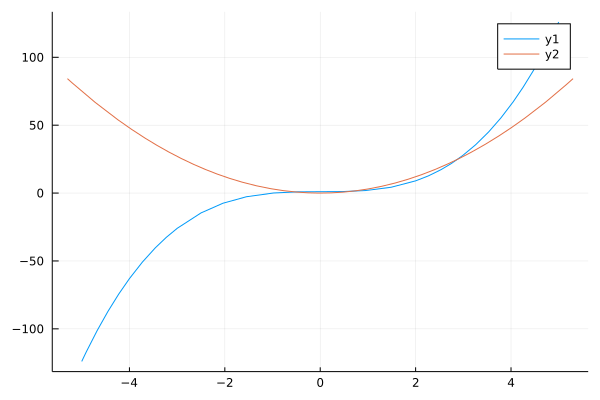

In [12]:
using Plots

f(x) = x^3 + 1
plot(f)
plot!(f')

In [13]:
@code_llvm f(2.0)

;  @ In[12]:3 within `f'
define double @julia_f_8068(double %0) {
top:
; ┌ @ intfuncs.jl:313 within `literal_pow'
; │┌ @ operators.jl:560 within `*' @ float.jl:332
    %1 = fmul double %0, %0
    %2 = fmul double %1, %0
; └└
; ┌ @ promotion.jl:321 within `+' @ float.jl:326
   %3 = fadd double %2, 1.000000e+00
; └
  ret double %3
}


In [14]:
@code_llvm f'(2.0)

;  @ /home/mfh/.julia/packages/Zygote/ggM8Z/src/compiler/interface.jl:52 within `#43'
define double @"julia_#43_8098"(double %0) {
top:
; ┌ @ /home/mfh/.julia/packages/Zygote/ggM8Z/src/compiler/interface.jl:49 within `gradient'
; │┌ @ /home/mfh/.julia/packages/Zygote/ggM8Z/src/compiler/interface.jl:40 within `#41'
; ││┌ @ In[12]:3 within `Pullback'
; │││┌ @ /home/mfh/.julia/packages/ZygoteRules/OjfTt/src/adjoint.jl:59 within `#1752#back'
; ││││┌ @ /home/mfh/.julia/packages/Zygote/ggM8Z/src/lib/number.jl:6 within `#185'
; │││││┌ @ intfuncs.jl:312 within `literal_pow'
; ││││││┌ @ float.jl:332 within `*'
         %1 = fmul double %0, %0
; │││││└└
; │││││┌ @ promotion.jl:322 within `*' @ float.jl:332
        %2 = fmul double %1, 3.000000e+00
; └└└└└└
  ret double %2
}


## Speed

Let's compare to C and python ...

In [15]:
v = randn(10^7);   # Large vector of numbers

In [16]:
using BenchmarkTools

In [17]:
# Compile some C code and call it from julia ...
using Libdl
code = """
#include <stddef.h>
double c_sum(size_t n, double *v) {
    double accu = 0.0;
    for (size_t i = 0; i < n; ++i) {
        accu += v[i];
    }
    return accu;
}
"""

# Compile to a shared library (with fast maths and machine-specific)
const Clib = tempname()
open(`gcc -fPIC -O3 -march=native -xc -shared -ffast-math -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, code) 
end

# define a Julia function that calls the C function:
c_sum(v::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(v), v)

c_sum (generic function with 1 method)

In [18]:
bench = @benchmark c_sum($v)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     3.781 ms (0.00% GC)
  median time:      3.968 ms (0.00% GC)
  mean time:        4.102 ms (0.00% GC)
  maximum time:     7.162 ms (0.00% GC)
  --------------
  samples:          1216
  evals/sample:     1

In [19]:
times = Dict()
times["C"] = minimum(bench.times) / 1e6
times

Dict{Any, Any} with 1 entry:
  "C" => 3.78127

How does our version do?

In [20]:
bench = @benchmark mysum($v)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     9.676 ms (0.00% GC)
  median time:      9.724 ms (0.00% GC)
  mean time:        9.770 ms (0.00% GC)
  maximum time:     10.484 ms (0.00% GC)
  --------------
  samples:          512
  evals/sample:     1

In [21]:
times["Julia (naive)"] = minimum(bench.times) / 1e6

9.675964

But unlike C we have not yet tried all tricks!

In [22]:
function fastsum(v)
    result = zero(eltype(v))
    @simd for i in 1:length(v)    # @simd enforces vectorisation in the loop
        @inbounds result += v[i]  # @inbounds suppresses bound checks
    end
    result
end

# Still nicely readable code ...

fastsum (generic function with 1 method)

In [23]:
bench = @benchmark fastsum($v)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     3.815 ms (0.00% GC)
  median time:      3.970 ms (0.00% GC)
  mean time:        4.107 ms (0.00% GC)
  maximum time:     7.028 ms (0.00% GC)
  --------------
  samples:          1215
  evals/sample:     1

In [24]:
times["Julia (simd)"] = minimum(bench.times) / 1e6

3.815298

Compare with python ...

In [25]:
using PyCall
numpysum(v) = pyimport("numpy").sum(v)

bench = @benchmark numpysum($v)

BenchmarkTools.Trial: 
  memory estimate:  480 bytes
  allocs estimate:  9
  --------------
  minimum time:     4.234 ms (0.00% GC)
  median time:      4.392 ms (0.00% GC)
  mean time:        4.462 ms (0.00% GC)
  maximum time:     6.043 ms (0.00% GC)
  --------------
  samples:          1119
  evals/sample:     1

In [26]:
times["Numpy"] = minimum(bench.times) / 1e6

4.233692

In [27]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

pysum = py"py_sum"

bench = @benchmark pysum($v)

BenchmarkTools.Trial: 
  memory estimate:  336 bytes
  allocs estimate:  6
  --------------
  minimum time:     723.029 ms (0.00% GC)
  median time:      730.284 ms (0.00% GC)
  mean time:        728.511 ms (0.00% GC)
  maximum time:     732.763 ms (0.00% GC)
  --------------
  samples:          7
  evals/sample:     1

In [28]:
times["Python (naive)"] = minimum(bench.times) / 1e6

723.02868

Overview ...

In [29]:
times

Dict{Any, Any} with 5 entries:
  "Numpy"          => 4.23369
  "C"              => 3.78127
  "Julia (naive)"  => 9.67596
  "Python (naive)" => 723.029
  "Julia (simd)"   => 3.8153